<a href="https://colab.research.google.com/github/pysr1/colab_stuff/blob/master/mondrian_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install scikit-garden

     |████████████████████████████████| 317kB 2.7MB/s 
  Created wheel for scikit-garden: filename=scikit_garden-0.1.3-cp36-cp36m-linux_x86_64.whl size=675299 sha256=26a3722259a3b87c6df9b66bee8f785fb51223ef261d2560cb75176b3b1f0e5d
  Stored in directory: /root/.cache/pip/wheels/d0/ef/71/3a032ba9a2b70690c9f9ec2e383afee6610f509af312ff2cf3
Successfully built scikit-garden


# Probabalistic Regression for With Mondrian Forests

In [0]:
# import core data science python packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 


train = pd.read_csv('sample_data/california_housing_train.csv')

In [3]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [4]:
plt.figure(figsize = (12, 8))
train.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1,-0.925208,-0.11425,0.0470104,0.071802,0.101674,0.0596277,-0.015485,-0.0449817
latitude,-0.925208,1,0.0164539,-0.0387726,-0.0693729,-0.111261,-0.0749023,-0.080303,-0.144917
housing_median_age,-0.11425,0.0164539,1,-0.360984,-0.320434,-0.29589,-0.302754,-0.115932,0.106758
total_rooms,0.0470104,-0.0387726,-0.360984,1,0.928403,0.86017,0.919018,0.195383,0.130991
total_bedrooms,0.071802,-0.0693729,-0.320434,0.928403,1,0.881169,0.98092,-0.0134947,0.0457831
population,0.101674,-0.111261,-0.29589,0.86017,0.881169,1,0.909247,-0.000637629,-0.0278501
households,0.0596277,-0.0749023,-0.302754,0.919018,0.98092,0.909247,1,0.00764372,0.0610306
median_income,-0.015485,-0.080303,-0.115932,0.195383,-0.0134947,-0.000637629,0.00764372,1,0.691871
median_house_value,-0.0449817,-0.144917,0.106758,0.130991,0.0457831,-0.0278501,0.0610306,0.691871,1


<Figure size 864x576 with 0 Axes>

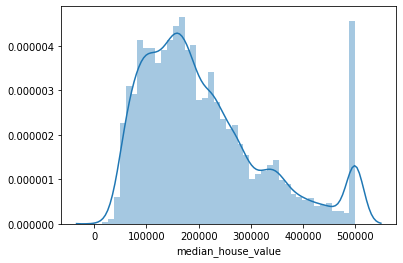

In [5]:
sns.distplot(train['median_house_value'])

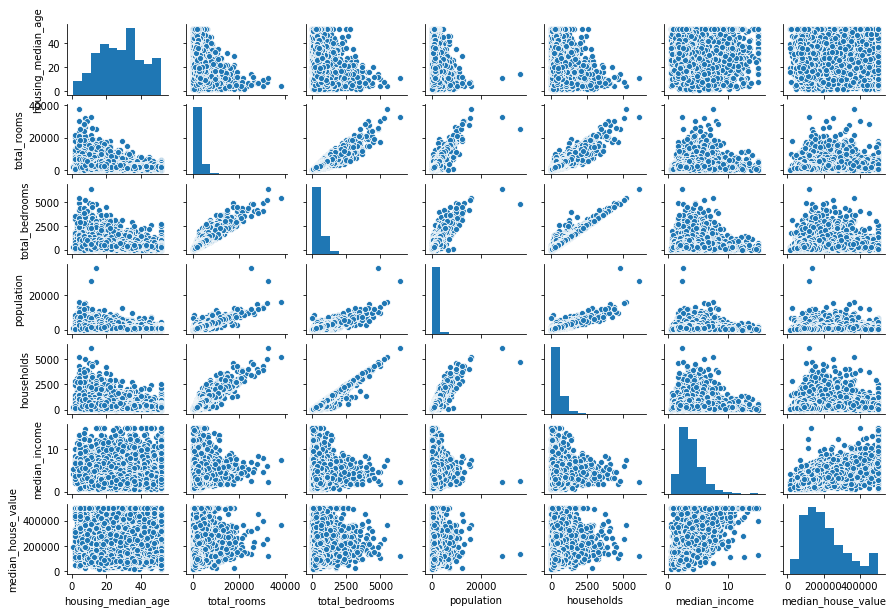

In [6]:
plot_vars = train.loc[:,'housing_median_age':'median_house_value']
ax = sns.pairplot(plot_vars)
ax.fig.set_size_inches(12,8)

In [7]:
from skgarden.mondrian import MondrianForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

test = pd.read_csv('sample_data/california_housing_test.csv')

X_train, y_train = (train.drop('median_house_value', 1), train['median_house_value'])
X_test, y_test = (test.drop('median_house_value', 1), test['median_house_value'])

# throw in a few asserts as QC checks
assert len(X_train) != len(X_test)
assert len(y_train) != len(y_test)

mfr = MondrianForestRegressor(n_estimators=100)


basic_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('ridge', mfr)])
basic_pipe = basic_pipe.fit(X_train, y_train)

print(basic_pipe.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


0.7155746013738278


In [8]:
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

test = pd.read_csv('sample_data/california_housing_test.csv')

X_train, y_train = (train.drop('median_house_value', 1), train['median_house_value'])
X_test, y_test = (test.drop('median_house_value', 1), test['median_house_value'])

# throw in a few asserts as QC checks
assert len(X_train) != len(X_test)
assert len(y_train) != len(y_test)

rf = XGBRegressor(n_estimators = 750, max_depth=7)


rf_pipe = Pipeline([
    ('ridge', rf)])
rf_pipe = rf_pipe.fit(X_train, y_train)

print(rf_pipe.score(X_test, y_test))

[00:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8285939754026613


In [9]:
X_test['mu_pred'], X_test['sd_pred'] = basic_pipe.predict(X_test, return_std = True)
X_test['y_true'] = y_test
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,mu_pred,sd_pred,y_true
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,365517.178984,80274.095841,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,212868.915234,72131.318168,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,285116.314063,81889.099755,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,246485.150078,106887.012006,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,83541.770000,32559.618174,81700.0


In [0]:
def plot_dist(row):
  mu = round(row['mu_pred'], 2)
  sd = row['sd_pred']
  true = row['y_true']
  #xgboost = rf_pipe.predict(row.drop(['mu_pred', 'sd_pred', 'y_true'], 1))
  dist = np.random.normal(mu, sd, 10000)
  upper = round(mu + sd, 2)
  lower = round(mu - sd, 2)
  plt.figure(figsize=(10, 4))
  sns.distplot(dist, label = 'Posterior')
  plt.plot([lower, upper], [0, 0], linewidth=3, c='k', marker='o', 
         label='mu + or - Standard Error')
  plt.axvline(mu, label = 'Posterior Mean')
  plt.axvline(true, label = 'True Value', color = 'C1')
  #plt.axvline(xgboost, color = 'C2')
  plt.legend()
  plt.title("We can expect the Price of this house to be about {}\nprice will be between {} and {}".format(mu, lower, upper))
  plt.show()


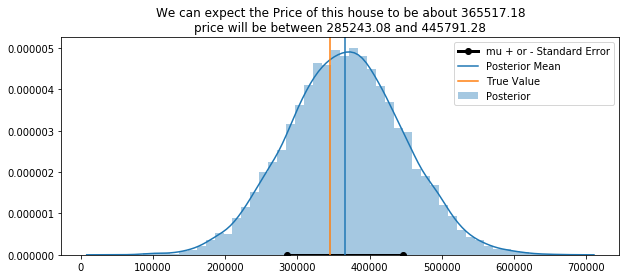

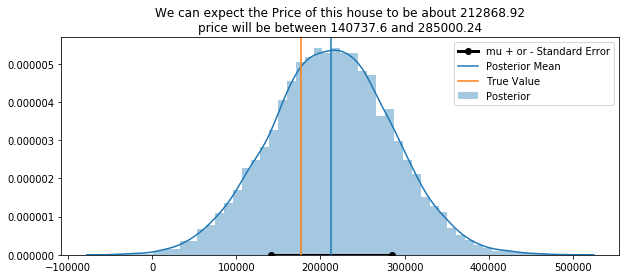

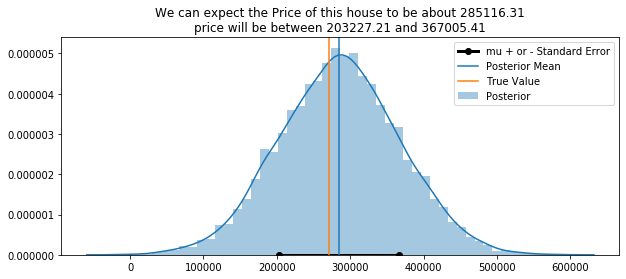

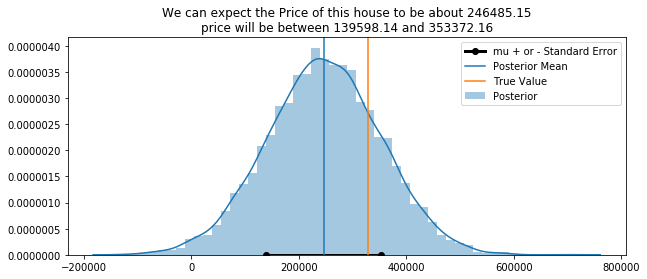

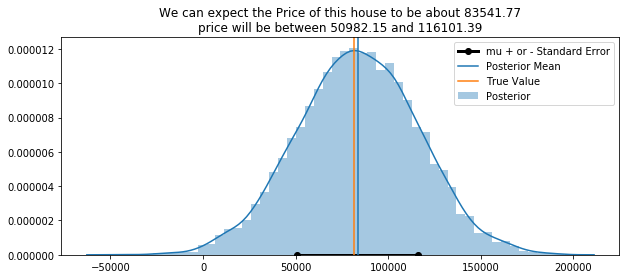

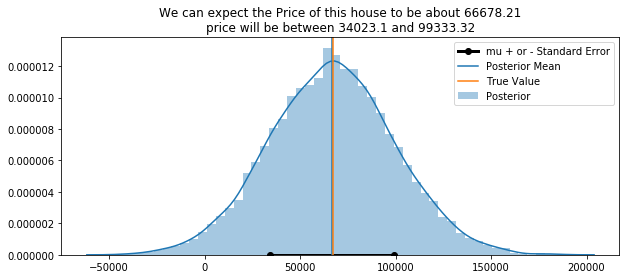

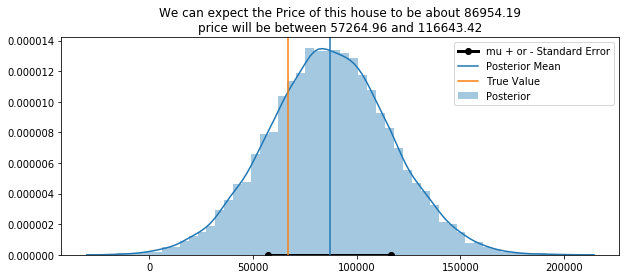

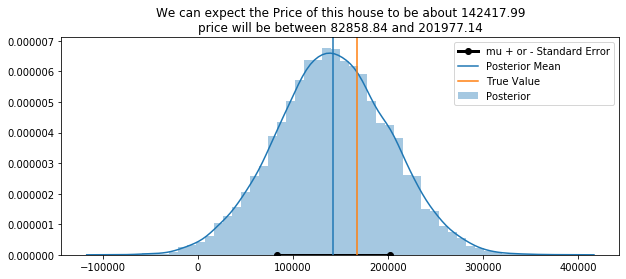

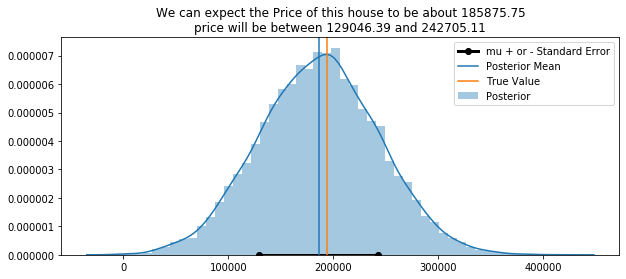

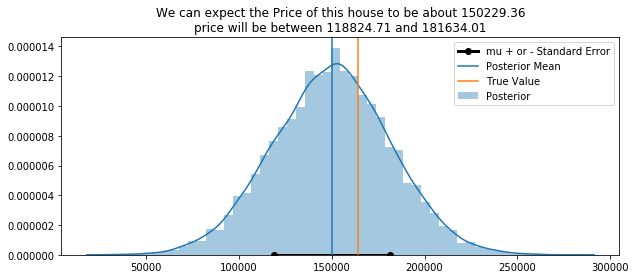

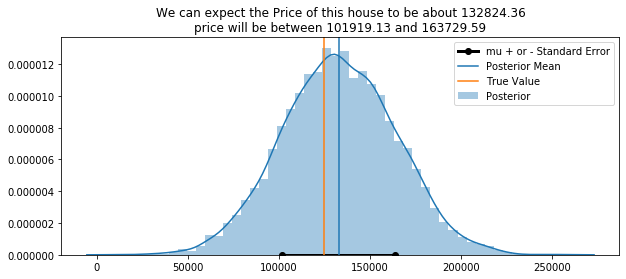

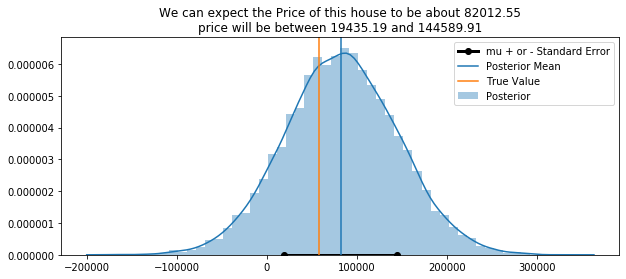

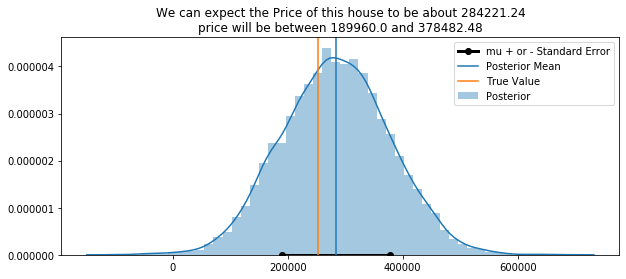

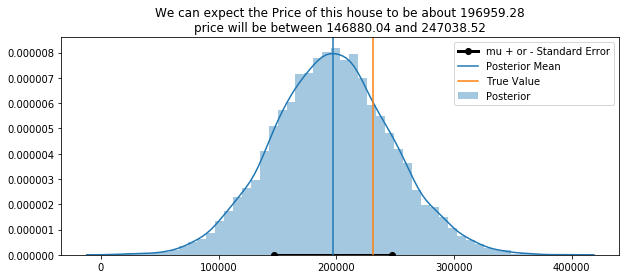

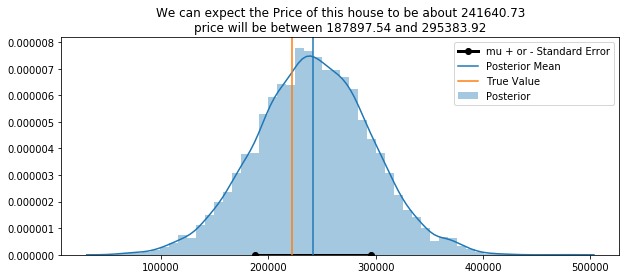

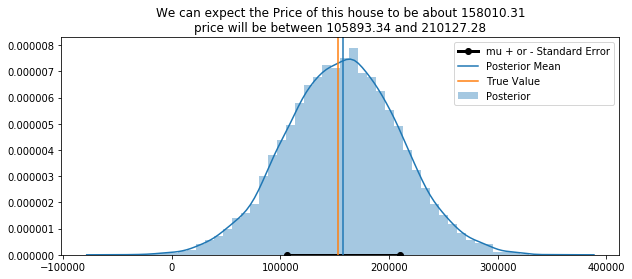

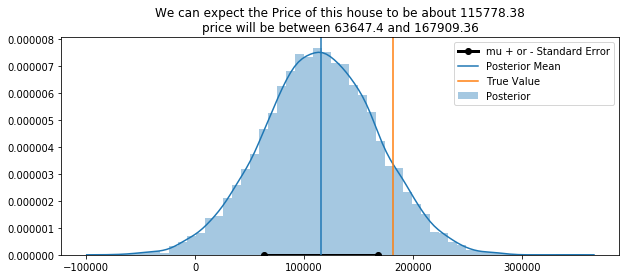

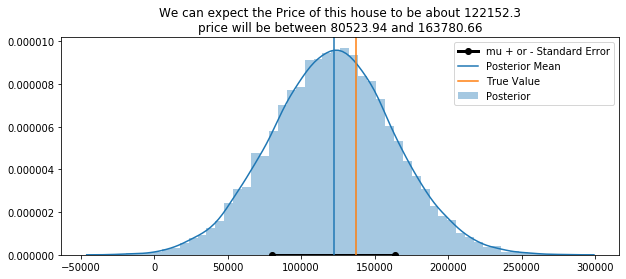

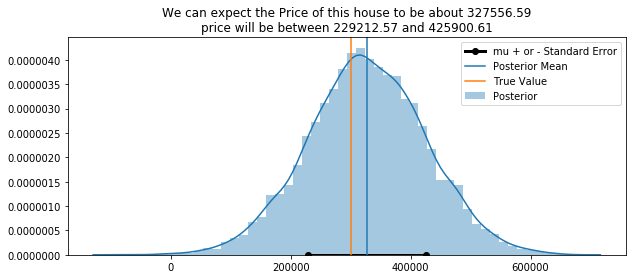

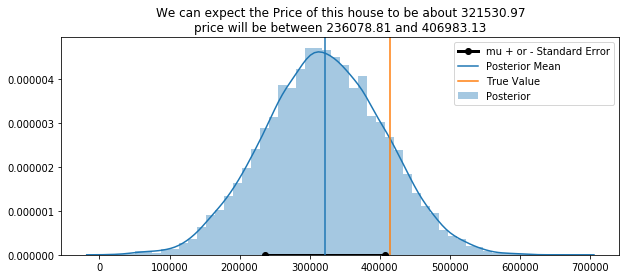

In [11]:
for i in range(20):
  plot_dist(X_test.loc[i, :])

In [13]:
def check_interval(row):
  mu = round(row['mu_pred'], 2)
  sd = row['sd_pred']
  true = row['y_true']
  upper = round(mu + sd, 2)
  lower = round(mu - sd, 2)
  coverage = 0
  if true > upper:
    coverage += 1
  elif true < lower:
    coverage += 1
  else:
    pass
  return coverage

X_test['Coverage'] = X_test.apply(check_interval, 1)
1 - X_test['Coverage'].mean()

0.8566666666666667